In [1]:
# Temorarily add source code path
import sys
import os
sys.path.insert(0, os.path.realpath('../'))

In [2]:
# Standard imports
import pandas as pd
import numpy as np
import requests
from helpers import *
import matplotlib.pyplot as plt
from bs4 import BeautifulSoup

%matplotlib inline

In [3]:
# Create NSE Object
from nse import NSE
nse = NSE()

In [4]:
returns = nse.get_symbol_eod_values()
close = nse.get_symbol_eod_values(data='close')
returns['2017-2'].head()

symbol,20microns,3iinfotech,3mindia,63moons,8kmiles,a2zinfra,aartidrugs,aartiind,aarveeden,aban,...,zeemedia,zenithexpo,zensartech,zentec,zicom,zodiacloth,zodjrdmkj,zuari,zuariglob,zyduswell
date,,,,,,,,,,,,,,,,,,,,,
2017-02-01,0.024220,0.000000,-0.016327,0.009901,0.005314,0.013150,0.000726,0.018825,0.004066,0.010625,...,0.020094,NaN,-0.012909,0.015079,-0.001133,-0.022503,NaN,-0.011227,0.000880,0.003281
2017-02-02,0.016240,-0.018019,-0.007483,0.006751,0.024484,0.010632,-0.008017,0.007215,0.011528,0.028058,...,0.009241,NaN,0.009599,-0.004773,0.007905,0.012118,-0.050661,0.000903,0.004390,-0.011095
2017-02-03,0.003711,0.000000,-0.006401,0.012158,0.006898,-0.005893,0.002598,0.034855,0.048108,-0.029685,...,0.010458,NaN,-0.004054,0.004093,-0.001125,0.029018,-0.038659,-0.025592,0.009590,0.005967
2017-02-06,0.021979,0.000000,0.032559,0.018558,-0.003324,0.024520,0.026726,0.019780,0.018399,0.005077,...,-0.030365,0.008386,0.012783,0.105837,0.008969,-0.027948,-0.014706,0.009674,0.039554,0.000462
2017-02-07,-0.010929,0.018019,-0.007819,-0.013736,-0.013649,0.038466,-0.008166,0.007166,-0.020586,-0.010179,...,-0.017580,NaN,0.005057,-0.076986,0.000000,0.041634,0.013245,-0.008440,-0.028338,-0.007709


In [ ]:
symbols = ['hindalco', 'rblbank', 'mmtc', 'infy']
close = close[symbols]['2016':]
returns = returns[symbols]['2016':]

In [5]:
from trades import Zerodha
z = Zerodha()
z.force_load_trades_data()

D:\dev\projects\python\stock_analysis\source\trades.py:260: RuntimeWarning: divide by zero encountered in log
  holdings.loc[date:, symbol] / holdings.loc[date:, symbol].shift(1)


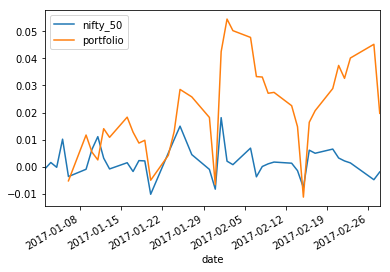

In [18]:
# trades = z.get_trades(trades_type='all')
my = z.get_profits().sum(axis=1) / z.get_holdings().sum(axis=1)
n50 = nse.get_index_eod_values('simple_returns', index_list='nifty_50')['2017']
# trades.date.min()
n50.join(my.rename('portfolio')).plot()

In [ ]:
profits_per_day = pd.DataFrame(
    0, index=z.get_traded_dates(start=trades.date.min()).index,
    columns=trades.symbol.unique()
)
profits = z.get_profits(trades=trades)

for trade in trades.itertuples():
    symbol = trade.symbol
    date = trade.date
    profits_per_day.loc[date:, symbol] = (
        profits.loc[date:, symbol] - profits.loc[date:, symbol].shift(1)
    )
    profits_per_day.loc[date, symbol] = profits.loc[date, symbol]
profits_per_day

In [ ]:
trades= z.read_trades()
fig = plt.figure(figsize=(10,5))
ax = fig.add_subplot(111)
# Holdings Plot
# trades[4].replace(0, np.nan).plot(ax=ax)

# Returns cumsum plot
# returns = trades[6].replace(0, np.nan).cumsum()
# returns = 100 * np.exp(returns)
# returns.plot(ax=ax)

# Profits plot
(trades[2]/trades[1]).plot(ax=ax)
ax.legend(loc="upper left", bbox_to_anchor=(1,1))

In [ ]:
classified_trasactions = pd.DataFrame(columns=transactions.columns)
# categorize transactions into intraday or open positions or closed positions
open_ = transactions.symbol.value_counts()
open_ = open_[open_ == 1].index
cond = transactions.symbol.isin(open_)
transactions.loc[cond, ['open_con']] = True
# open_trans = transactions.loc[cond, :]

# classified_trasactions = classified_trasactions.append(open_trans, ignore_index=True)
# transactions = transactions.drop(open_trans.index).reset_index(drop=True)

intra = transactions.groupby(['date', 'symbol']).quantity.sum().reset_index()
intra = intra.query('quantity == 0')
cond = (transactions.date.isin(intra.date)) & (transactions.symbol.isin(intra.symbol))
transactions.loc[cond, ['intra']] = True
# intra_trans = transactions.loc[cond, :]

# classified_trasactions = classified_trasactions.append(intra_trans, ignore_index=True)
# transactions = transactions.drop(intra_trans.index).reset_index(drop=True)

symbol_group = transactions.groupby(['symbol']).quantity.sum().reset_index()
closed = symbol_group.query('quantity == 0')
cond = transactions.symbol.isin(closed.symbol)
transactions.loc[cond, 'closed'] = True

open_ = symbol_group.query('quantity != 0')
cond = transactions.symbol.isin(open_.symbol)
transactions.loc[cond, 'open'] = True
# closed_trans = transactions.loc[cond, :]

# classified_trasactions = classified_trasactions.append(closed_trans, ignore_index=True)
# transactions = transactions.drop(closed_trans.index).reset_index(drop=True)
transactions
# closed_trans

In [ ]:
trades[4][['tatamotors']].join(trades[1]['tatamotors'].rename('inv')).join(trades[5]['tatamotors'].rename('qty')).join(trades[2]['tatamotors'].rename('profits')).join(trades[3]['tatamotors'].rename('ppd'))

In [ ]:
trades[2].sum(axis=1)

In [ ]:
trades[0].set_index('date')['2017-02-15':]

In [ ]:
get_adjacent_dates(trades[4].index, '2017-02-03')

In [ ]:
ledger = pd.read_excel('..\\data\\ledger.xlsx', skiprows=13, parse_cols='B:J').dropna(subset=['Date'])
rename_columns(ledger)
ledger['date'] = pd.to_datetime(ledger['date'], format='%d/%m/%Y')
cash = ledger.loc[ledger.particulars.str[:5] == 'Being', ['date', 'debit', 'credit']]
# cash.set_index('date', inplace=True)
cash['debit'] = -1 * cash['debit']
cash['cash'] = cash.sum(axis=1)
cash = cash.groupby('date').cash.sum().cumsum()

In [ ]:
portfolio_value = pd.DataFrame(0, index=nse.get_traded_dates(start=trades.date.min()).index, columns=trades.symbol.unique())
returns_portfolio = portfolio_value.copy().replace(0, np.nan)
weights = portfolio_value.copy()
portfolio_value['cash']= portfolio_value.join(cash, how='outer').cash.ffill()
portfolio_value['cash_balance']= portfolio_value['cash'].copy()
debug_df = pd.DataFrame(
    columns=['rate', 'qty', 'existing_worth', 'existing_qty', 'new_worth', 'new_qty', ]
)
i=0
for trade in trades.itertuples():
    date = trade.date
    time = trade.time
    symbol = trade.symbol
    ttype = trade.type
    rate = trade.rate
    qty = trade.qty
    
    if symbol not in close.columns:
        continue
    
    price = trade.price
    portfolio_value.loc[date:, 'cash_balance'] = portfolio_value.loc[date:, 'cash_balance'] - price
    
    # Find existing quantity and worth(EOD close) from portfolio_value
    existing_worth = portfolio_value.loc[date, symbol]
    existing_qty = existing_worth /  close[symbol][date]
    
    # Find Quantity after transaction
    new_qty = existing_qty + qty
    new_worth = ((existing_worth) + (rate * qty))
    
    if symbol == 'tatamotors':
        debug_df.loc[i] = (rate, qty, existing_worth, existing_qty, new_worth, new_qty, )
        i = i+1
    if  new_qty != 0:
        # Normal buy transaction
        rate = new_worth / new_qty
       
        returns_portfolio.loc[date:, symbol] = returns[symbol][date:]
        returns_portfolio.loc[date, symbol] = np.log(close[symbol][date] / rate)
    elif new_qty == 0:
        # Short Sell => Cover transaction
        rate = rate # rate will be the rate of transaction
        prev_close = close[symbol].shift(1)[date]

        returns_portfolio.loc[date:, symbol] = np.nan # No furter quantity so returns become 0
        returns_portfolio.loc[date, symbol] = np.log(rate / prev_close)

    portfolio_value.loc[date:, symbol] = new_qty * close[symbol][date:]
    weights.loc[date:, symbol] = new_qty
#     if ttype == 1:
#         # Buy transaction
        
        
#     elif ttype == -1:
#         if ttype == 1:
#             new_qty = existing_qty + qty
#             new_worth = existing_worth + price
#         else:
#             new_qty = existing_qty + qty
#             new_worth = existing_worth - price
#             if new_qty != 0:
#                 pass
# #                 print(trade)
#         portfolio_value.loc[date:, symbol] = new_qty * close[symbol][date:]
#         print(new_qty, new_worth)
#         print(portfolio_value.replace(0, np.nan).dropna(how='all'))
something = portfolio_value.drop(['cash'], axis=1).sum(axis=1)
# something = (something / np.abs(something.ix[0])).rename('port')

# portfolio_value[['cash']].join(something.rename('sdf'))['2017-01-25':].plot()
# profit = np.log(something.rename('sdf') / portfolio_value['cash'])['2017-01-25':]
# (100 * np.exp(profit.cumsum())).plot()
# profit
# something = something.rename('sdf')['2017-01-25':]
# ret = np.log(something / something.shift(1))
# # (100 * np.exp(ret.cumsum())).plot()
# fig = plt.figure(figsize=(10,5))
# ax = fig.add_subplot(111)
# (100 * np.exp(returns_portfolio.cumsum())).plot(ax=ax)
# ax.legend(loc="upper left", bbox_to_anchor=(1,1))
# returns_portfolio.sum()
# returns_portfolio['tatamotors']
# returns[['tatamotors']]
debug_df

In [ ]:
n50_ret = nse.get_index_eod_values(data='returns', index_list='nifty_50', start='2017')
# 1*np.exp(n50_ret.cumsum()) 
n50_ret = n50_ret.join(ret)
ret = n50_ret.dropna()
(np.exp(ret.cumsum())).plot()

In [ ]:
(21700 - 21000)/ 20000

In [ ]:
(8900 - 8150) / 8150